In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import random

# Constants
SEQUENCE_LENGTH = 10

DATASET_SIZE = 10000
EMBEDDING_DIM = 192  # Matches the expected input size of the LSTM
HIDDEN_DIM = 256
VOCAB_SIZE = 20

LEARNING_RATE = 0.001
EPOCHS = 30
BATCH_SIZE = 64

In [40]:
# Synthetic Dataset
class ReverseSequenceDataset(Dataset):
    def __init__(self, size, seq_len, vocab_size):
        self.data = [torch.randint(1, vocab_size, (seq_len,)) for _ in range(size)]
        self.targets = [seq.flip(0) for seq in self.data]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# Splitting into Train and Test Sets
train_size = int(0.8 * DATASET_SIZE)
test_size = DATASET_SIZE - train_size
dataset = ReverseSequenceDataset(DATASET_SIZE, SEQUENCE_LENGTH, VOCAB_SIZE)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
train_dataset[0]

(tensor([15, 19, 17, 13, 15,  7, 11, 12, 14, 10]),
 tensor([10, 14, 12, 11,  7, 15, 13, 17, 19, 15]))

In [50]:
test_dataset[0]

(tensor([ 5,  7, 14,  4,  8,  8, 14, 10, 18,  8]),
 tensor([ 8, 18, 10, 14,  8,  8,  4, 14,  7,  5]))

In [41]:
# Model Components
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)  # input size is embedding_dim

    def forward(self, x):
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        outputs, (hidden, cell) = self.rnn(embedded)  # Pass to LSTM
        return outputs, hidden, cell


In [42]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.context = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch_size, hidden_dim)
        # encoder_outputs: (batch_size, seq_len, hidden_dim)
        attention_weights = torch.tanh(self.attn(encoder_outputs))  # (batch_size, seq_len, hidden_dim)
        attention_weights = self.context(attention_weights)  # (batch_size, seq_len, 1)
        attention_weights = torch.softmax(attention_weights, dim=1)  # (batch_size, seq_len, 1)
        return attention_weights.squeeze(-1)  # (batch_size, seq_len)


In [43]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, batch_first=True)  # Corrected to expect embedding + hidden_dim
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.attention = Attention(hidden_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)  # (batch_size, 1)
        embedded = self.embedding(x)  # (batch_size, 1, embedding_dim)

        # Compute attention weights and context vector
        attention_weights = self.attention(hidden[-1], encoder_outputs)  # (batch_size, seq_len)
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # (batch_size, 1, hidden_dim)

        # Combine embedded input with context vector
        rnn_input = torch.cat((embedded, context), dim=2)  # (batch_size, 1, embedding_dim + hidden_dim)

        # Pass through LSTM
        outputs, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))  # (batch_size, 1, hidden_dim)

        predictions = self.fc(outputs.squeeze(1))  # Predict the next token (batch_size, vocab_size)
        return predictions, hidden, cell, attention_weights




In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.fc.out_features
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)

        encoder_outputs, hidden, cell = self.encoder(source)
        x = target[:, 0]
        for t in range(1, target_len):
            output, hidden, cell, _ = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            x = target[:, t] if teacher_force else output.argmax(1)

        return outputs

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)
decoder = Decoder(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# Training Setup
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []

In [46]:
def evaluate(loader, model):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for source, target in loader:
            source, target = source.to(device), target.to(device)
            outputs = model(source, target, teacher_forcing_ratio=0)
            predictions = outputs.argmax(2)
            correct += (predictions[:, 1:] == target[:, 1:]).sum().item()
            total += target[:, 1:].numel()
            loss = criterion(outputs[:, 1:].reshape(-1, VOCAB_SIZE), target[:, 1:].reshape(-1))
            total_loss += loss.item()
    return total_loss / len(loader), (correct / total) * 100


Epoch 1/30 | Train Loss: 1.9301 | Test Loss: 1.5479 | Test Accuracy: 36.19%
Epoch 2/30 | Train Loss: 1.0617 | Test Loss: 0.8718 | Test Accuracy: 70.48%
Epoch 3/30 | Train Loss: 0.4817 | Test Loss: 0.4243 | Test Accuracy: 89.79%
Epoch 4/30 | Train Loss: 0.2221 | Test Loss: 0.2346 | Test Accuracy: 95.82%
Epoch 5/30 | Train Loss: 0.1100 | Test Loss: 0.1234 | Test Accuracy: 98.56%
Epoch 6/30 | Train Loss: 0.0653 | Test Loss: 0.0894 | Test Accuracy: 99.10%
Epoch 7/30 | Train Loss: 0.0411 | Test Loss: 0.0715 | Test Accuracy: 99.22%
Epoch 8/30 | Train Loss: 0.0264 | Test Loss: 0.0613 | Test Accuracy: 99.33%
Epoch 9/30 | Train Loss: 0.0155 | Test Loss: 0.0383 | Test Accuracy: 99.65%
Epoch 10/30 | Train Loss: 0.0116 | Test Loss: 0.0564 | Test Accuracy: 99.37%
Epoch 11/30 | Train Loss: 0.0102 | Test Loss: 0.0302 | Test Accuracy: 99.74%
Epoch 12/30 | Train Loss: 0.0089 | Test Loss: 0.0852 | Test Accuracy: 98.98%
Epoch 13/30 | Train Loss: 0.1202 | Test Loss: 0.1122 | Test Accuracy: 98.02%
Epoch 14

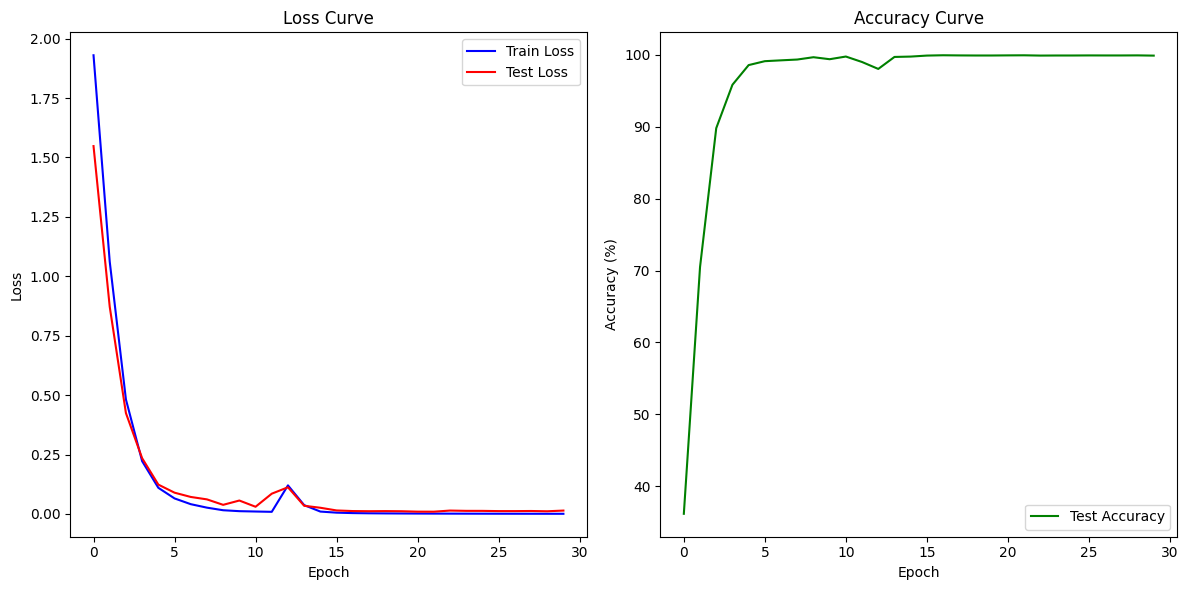

In [47]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for source, target in train_loader:
        source, target = source.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(source, target)
        loss = criterion(outputs[:, 1:].reshape(-1, VOCAB_SIZE), target[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    test_loss, test_accuracy = evaluate(test_loader, model)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{EPOCHS} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

# Plotting Loss and Accuracy
plt.figure(figsize=(12, 6))

# Plot Train/Test Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(test_losses, label="Test Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label="Test Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()